In [13]:
%matplotlib inline

# Introduction to Deep Learning with TensorFlow
Reference: This is based on tutorials written by Daniel Moser (UT Southwestern Medical Center), [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), and [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)

# Overview

Build two NN models for classifying handwritten numbers with accuracies surpassing 95%.

- The first model is a basic fully-connected neural network.
- The second model is a deep convolutional neural network.

MNIST database contains 60,000 images for training and 10,000 test images.


<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

# Loading Python  Modules


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# MNIST Data

The MNIST dataset is conveniently bundled within Keras

In [15]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

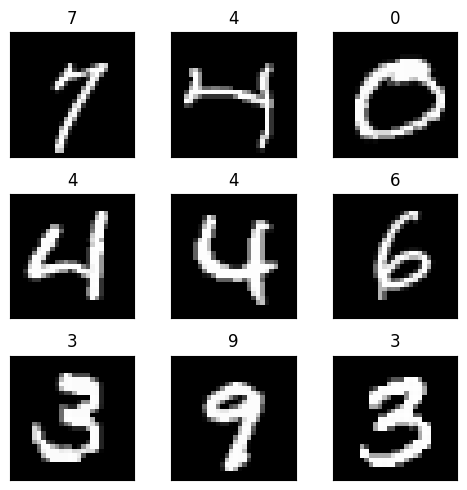

In [16]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
for i in range(9):
    plt.subplot(3,3,i+1)
    num = np.random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title(y_train[num])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

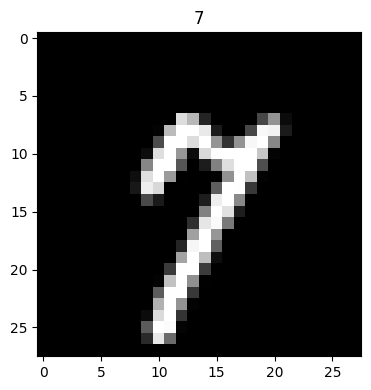


Each pixel is an 8-bit integer from 0-255.
0 is full black, while 255 is full white.

0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0   0   0   0   0   0   0   0   0   0  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   0   0 220 183  37   0   0   0   0  71 147 11 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0   3 186 254 254 232  27   0   0  71 247 241 27 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0   0  76 254 254 220 254 148  50 147 246 254 134  0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0  0  12 221 254 150  12 216 254 254 254 254 198   4  0 0 0 0 0 0 0 


In [17]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end=" ")
        print("")

num = np.random.randint(0, len(X_train))
plt.figure(figsize=(4,4))
plt.imshow(X_train[num], cmap='gray', interpolation='none')
plt.title(y_train[num])
plt.tight_layout()
plt.show()
print("\nEach pixel is an 8-bit integer from 0-255.\n0 is full black, while 255 is full white.\n")
matprint(X_train[num])

# Model 1: fully-connected neural network (FCN)

 ## Data pre-processing

### Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 28*28 =784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255].

In [18]:
# An example
xx = np.random.randint(1,10,(3,3))
print(xx)
print('\nflatten:\n',xx.flatten())

[[3 7 2]
 [2 3 8]
 [7 3 4]]

flatten:
 [3 7 2 2 3 8 7 3 4]


In [19]:
print("Training X matrix initial shape", X_train.shape)
print("Testing X matrix initial shape", X_test.shape)

X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

Training X matrix initial shape (60000, 28, 28)
Testing X matrix initial shape (10000, 28, 28)
Training X matrix shape (60000, 784)
Testing X matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

### Formatting the output data layer



In [20]:
nb_classes = 10 # number of unique digits

Y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
Y_test  = tf.keras.utils.to_categorical(y_test, nb_classes)

print("Training Y matrix shape",Y_train.shape)
print("Testing Y matrix shape",Y_test.shape)

Training Y matrix shape (60000, 10)
Testing Y matrix shape (10000, 10)


## Building the model

### Approach 1

In [21]:
model = tf.keras.Sequential()

# first layer
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))

# second layer
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))

# Third/output layer
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

### Approach 2

In [23]:
# The Sequential model is a linear stack of layers and is very common.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu',input_shape=(28*28,)),
    tf.keras.layers.Dropout(0.2),
    #--------------------------------------------------
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #--------------------------------------------------
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [24]:
# Summarize the built model
model.build(input_shape=(28*28,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compiling the model
When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)



In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # ,tf.keras.metrics.Precision()

## Training the model

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20) #, patience=3, baseline=0.4, min_delta=1

fit_output = model.fit(X_train, Y_train,
          batch_size=128,  # 32, 128, 10000
          epochs=6,
          validation_data=(X_test,Y_test),
          callbacks=[callback],
          verbose=1)



Epoch 1/6
469/469 [==============================] - 11s 21ms/step - loss: 0.2510 - accuracy: 0.9255 - val_loss: 0.1025 - val_accuracy: 0.9668
Epoch 2/6
469/469 [==============================] - 9s 20ms/step - loss: 0.1009 - accuracy: 0.9691 - val_loss: 0.0752 - val_accuracy: 0.9750
Epoch 3/6
469/469 [==============================] - 9s 19ms/step - loss: 0.0701 - accuracy: 0.9780 - val_loss: 0.0720 - val_accuracy: 0.9787
Epoch 4/6
469/469 [==============================] - 10s 21ms/step - loss: 0.0551 - accuracy: 0.9828 - val_loss: 0.0860 - val_accuracy: 0.9749
Epoch 5/6
469/469 [==============================] - 9s 19ms/step - loss: 0.0460 - accuracy: 0.9851 - val_loss: 0.0690 - val_accuracy: 0.9800
Epoch 6/6
469/469 [==============================] - 9s 19ms/step - loss: 0.0389 - accuracy: 0.9874 - val_loss: 0.0745 - val_accuracy: 0.9799


['loss', 'accuracy', 'val_loss', 'val_accuracy']


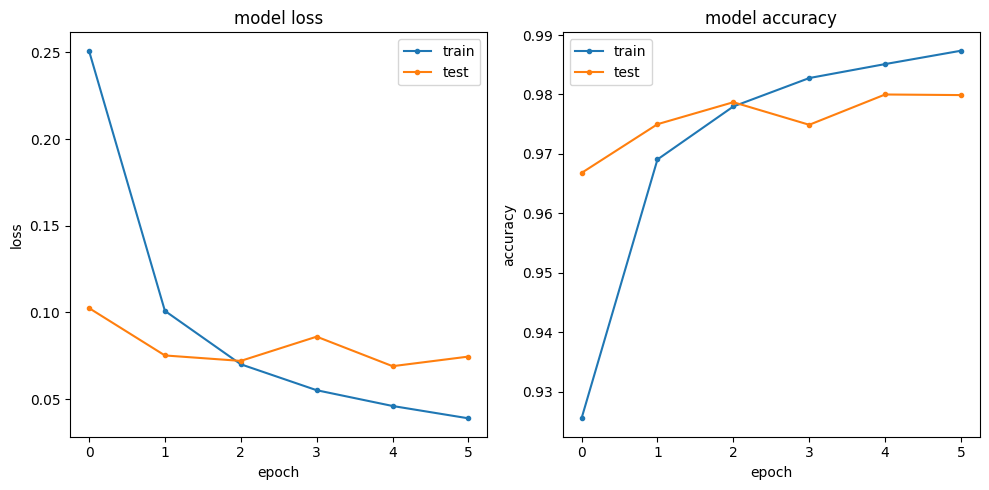

In [27]:
history = fit_output.history
# list all data in history
print(list(history.keys()))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
# summarize history for loss
plt.plot(history['loss'],'.-')
plt.plot(history['val_loss'],'.-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(1,2,2)
# summarize history for accuracy
plt.plot(history['accuracy'],'.-')
plt.plot(history['val_accuracy'],'.-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.tight_layout()
plt.show()

## Testing the model

In [28]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])
# print('Test accuracy:', score[2])

313/313 [==============================] - 1s 3ms/step - loss: 0.0745 - accuracy: 0.9799
Test score: 0.07450977712869644
Test accuracy: 0.9799000024795532


## Inspecting the predictions

It's always a good idea to inspect the output and make sure everything looks sane.

In [29]:
y_predicted = model.predict(X_test)

313/313 [==============================] - 2s 5ms/step


In [30]:
print(y_predicted.shape)
print(y_predicted[0:3,:])
print(np.argmax(y_predicted[0:3,:],axis=1))

(10000, 10)
[[1.2343106e-10 1.2692586e-09 4.5136595e-08 6.8438268e-08 7.7131954e-11
  2.7508867e-10 1.3159369e-12 9.9999982e-01 3.0062015e-11 4.6308246e-09]
 [4.5297086e-12 5.7966881e-06 9.9999410e-01 1.6551956e-08 7.2363211e-14
  5.2678005e-12 1.1932856e-10 8.6886845e-11 2.6973876e-09 6.9047581e-15]
 [8.9606011e-10 9.9999803e-01 9.1231458e-09 5.4820599e-11 1.3915057e-07
  7.0887168e-10 2.6807803e-09 1.6396720e-06 7.4485413e-08 4.8362918e-09]]
[7 2 1]


In [31]:
y_predicted = np.argmax(y_predicted,axis=1)

# Check which items we got right / wrong
correct_indices   = np.nonzero(y_predicted == y_test)[0]
incorrect_indices = np.nonzero(y_predicted != y_test)[0]


### Inspecting **correct** predictions

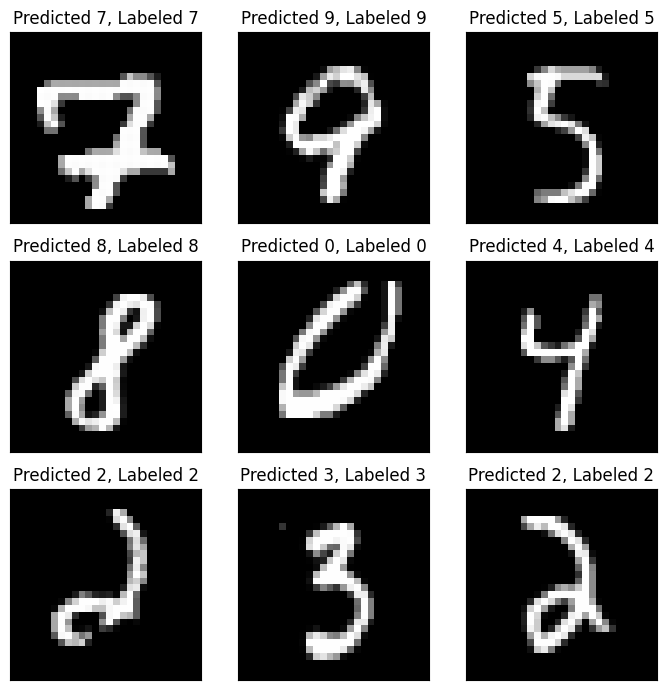

In [33]:
plt.figure(figsize=(7,7))
for i, correct in enumerate(correct_indices[np.random.randint(0,len(correct_indices),9)]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Labeled {}".format(y_predicted[correct], y_test[correct]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()


### Inspecting **incorrect** predictions

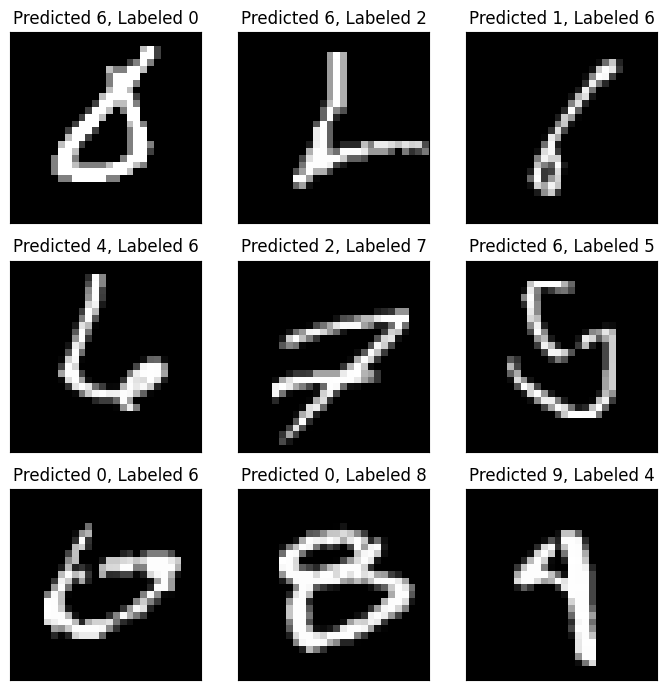

In [35]:
plt.figure(figsize=(7,7))
for i, incorrect in enumerate(incorrect_indices[np.random.randint(0,len(incorrect_indices),9)]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Labeled {}".format(y_predicted[incorrect], y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Model 2: Convolutional Neural Network

 ## Data pre-processing

### Loading data

In [45]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

### Formatting the input layer

In [46]:
print("Training X matrix initial shape", X_train.shape)
print("Testing X matrix initial shape", X_test.shape)
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

Training X matrix initial shape (60000, 28, 28)
Testing X matrix initial shape (10000, 28, 28)
Training X matrix shape (60000, 28, 28, 1)
Testing X matrix shape (10000, 28, 28, 1)


### Formatting the output layer

In [47]:
# one-hot format classes
nb_classes = 10 # number of unique digits
Y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
Y_test  = tf.keras.utils.to_categorical(y_test, nb_classes)

## Building the model

In [41]:
model = tf.keras.Sequential([
    #---------------------------------------
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D((2,2), padding='valid'),
    #---------------------------------------
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #---------------------------------------
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                      

## Compiling the model

In [42]:
# use the same optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training the model  (takes several minutes)

In [29]:
model.fit(X_train, Y_train,
          batch_size=512,
          epochs=5,
          validation_data=(X_test,Y_test))


Epoch 1/5
118/118 [==============================] - 215s 2s/step - loss: 0.2463 - accuracy: 0.9258 - val_loss: 0.0461 - val_accuracy: 0.9849
Epoch 2/5
118/118 [==============================] - 215s 2s/step - loss: 0.0470 - accuracy: 0.9855 - val_loss: 0.0347 - val_accuracy: 0.9882
Epoch 3/5
118/118 [==============================] - 212s 2s/step - loss: 0.0313 - accuracy: 0.9900 - val_loss: 0.0311 - val_accuracy: 0.9890
Epoch 4/5
118/118 [==============================] - 212s 2s/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0261 - val_accuracy: 0.9903
Epoch 5/5
118/118 [==============================] - 213s 2s/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0275 - val_accuracy: 0.9914


## Saving and loading a fitted model

In [48]:
action = 'load'
filename = '/content/drive/MyDrive/FEM505/MNIST_CNN_model.keras'

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # , force_remount=True

if action == 'save':
  model.save(filename)

elif action == 'load':
  from keras.models import load_model
  model = load_model(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# score = model.evaluate(X_train, Y_train)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 19s 59ms/step - loss: 0.0275 - accuracy: 0.9914
Test loss: 0.027485692873597145
Test accuracy: 0.9914000034332275


## Inspecting predictions

313/313 [==============================] - 15s 47ms/step


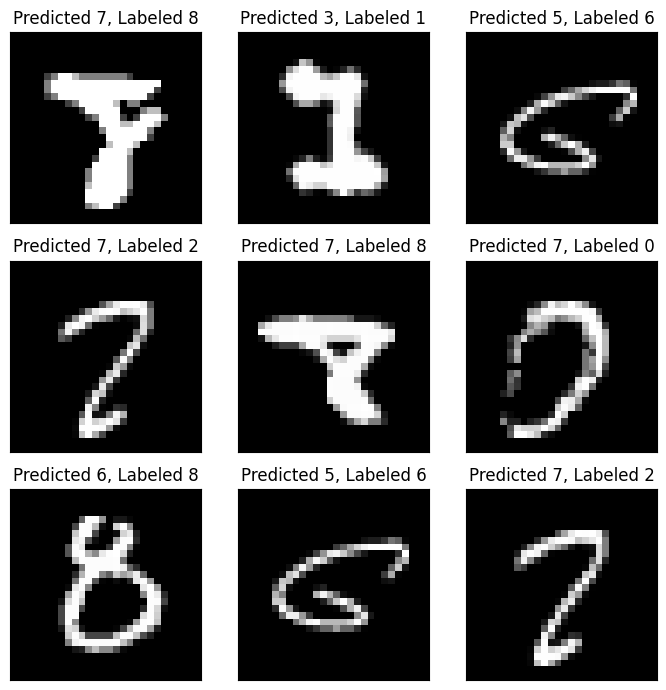

In [51]:
y_predicted = model.predict(X_test)
y_predicted = np.argmax(y_predicted,axis=1)
# Check which items we got right / wrong
correct_indices   = np.nonzero(y_predicted == y_test)[0]
incorrect_indices = np.nonzero(y_predicted != y_test)[0]

plt.figure(figsize=(7,7))
for i, incorrect in enumerate(incorrect_indices[np.random.randint(0,len(incorrect_indices),9)]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Labeled {}".format(y_predicted[incorrect], y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

## Looking at layers outputs

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

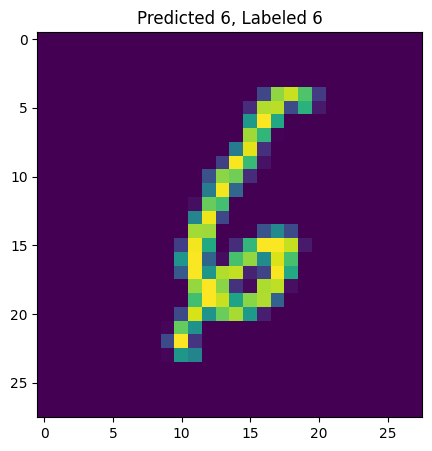

layer:  1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x786141dceef0>
Shape of conv: (26, 26, 32)


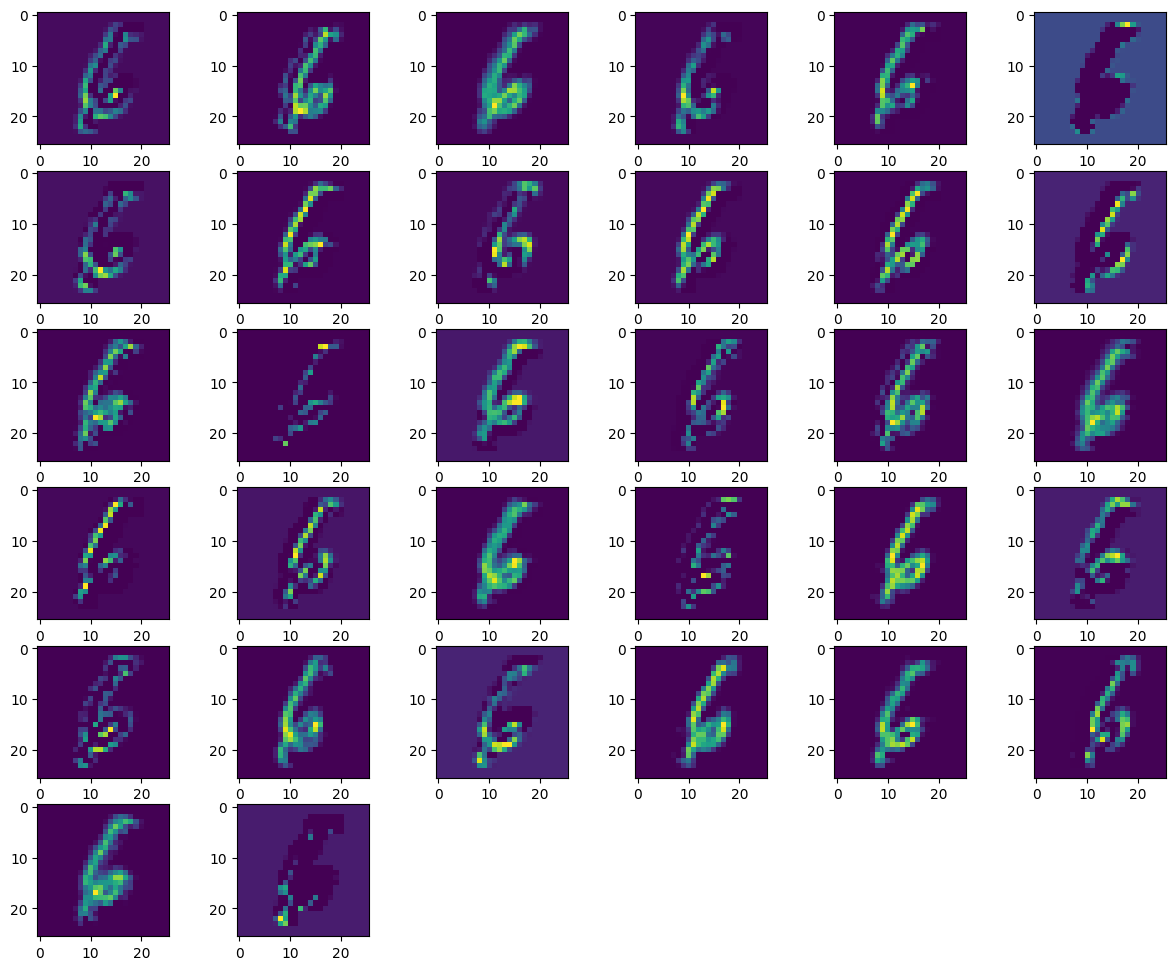

layer:  2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x786141dcd120>
Shape of conv: (24, 24, 32)


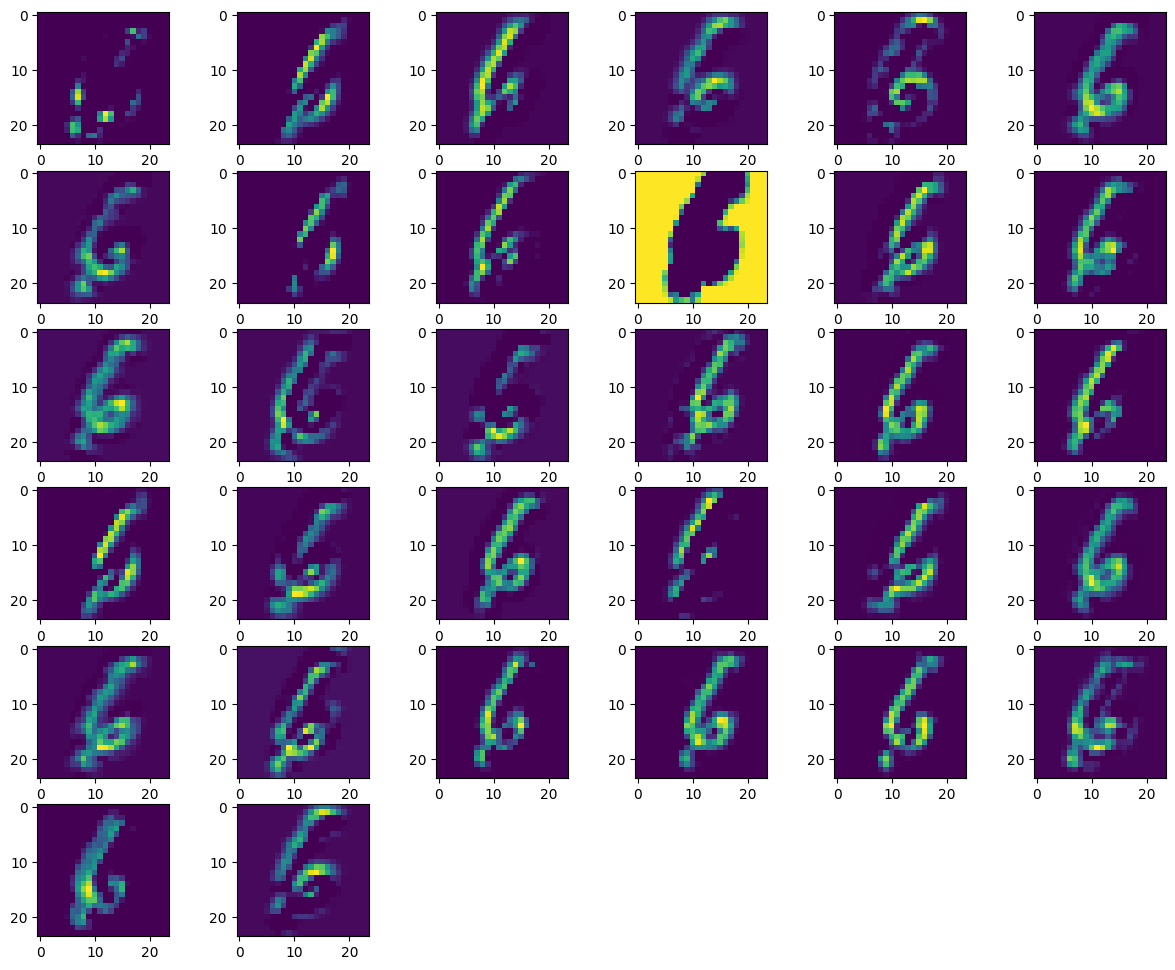

layer:  3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x786141d942b0>
Shape of conv: (22, 22, 64)


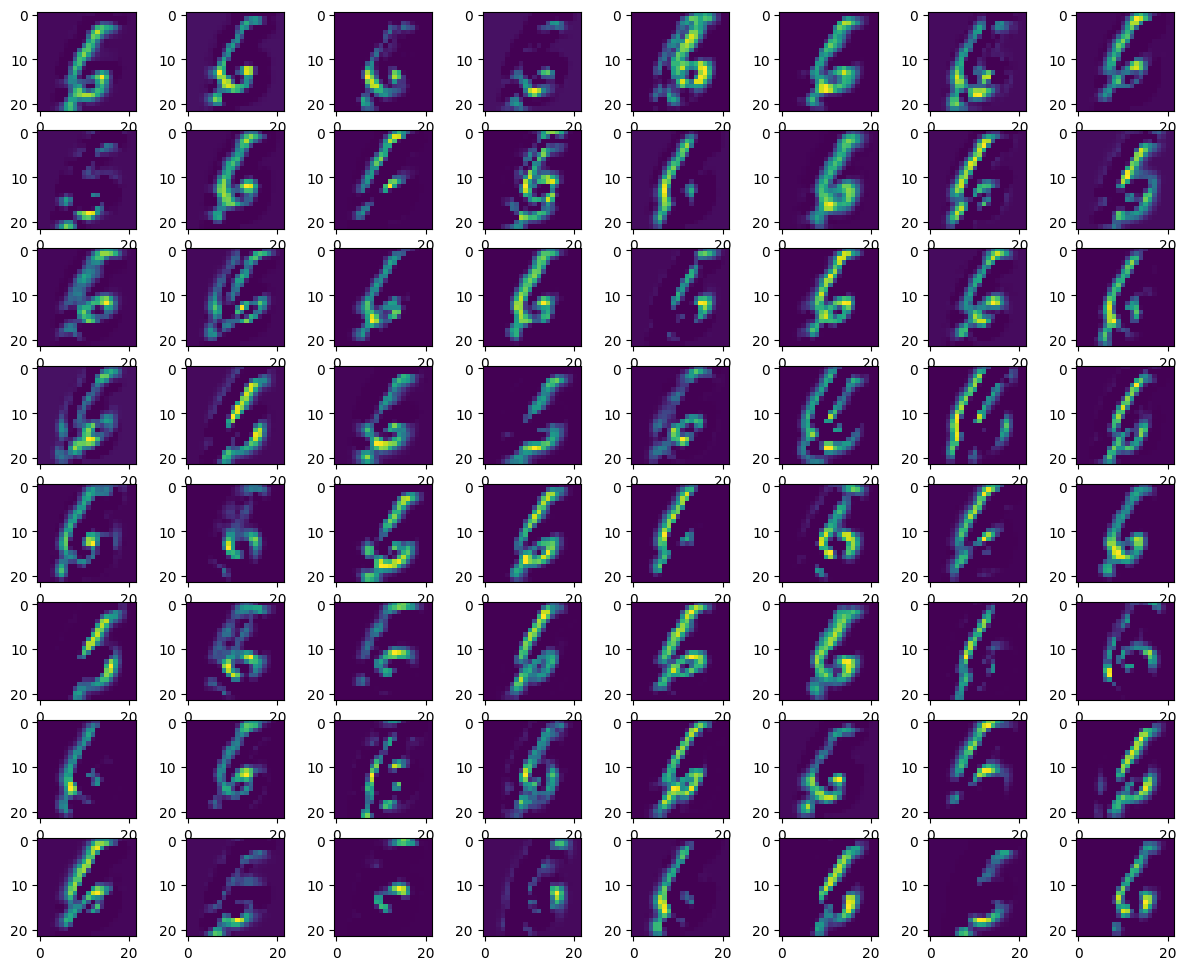

layer:  4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x786141d979d0>
Shape of conv: (20, 20, 64)


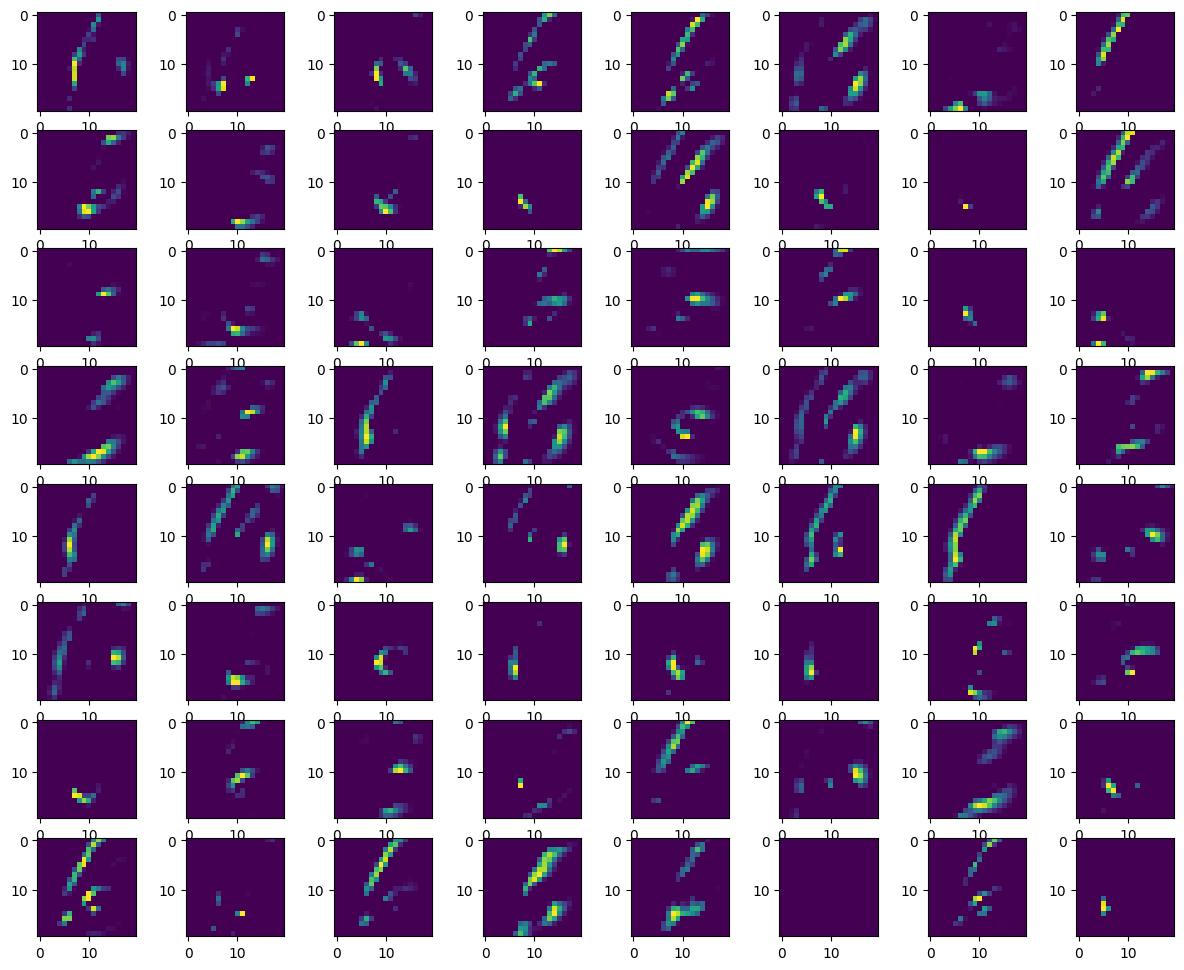

layer:  5 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x786141d94d90>
Shape of conv: (10, 10, 64)


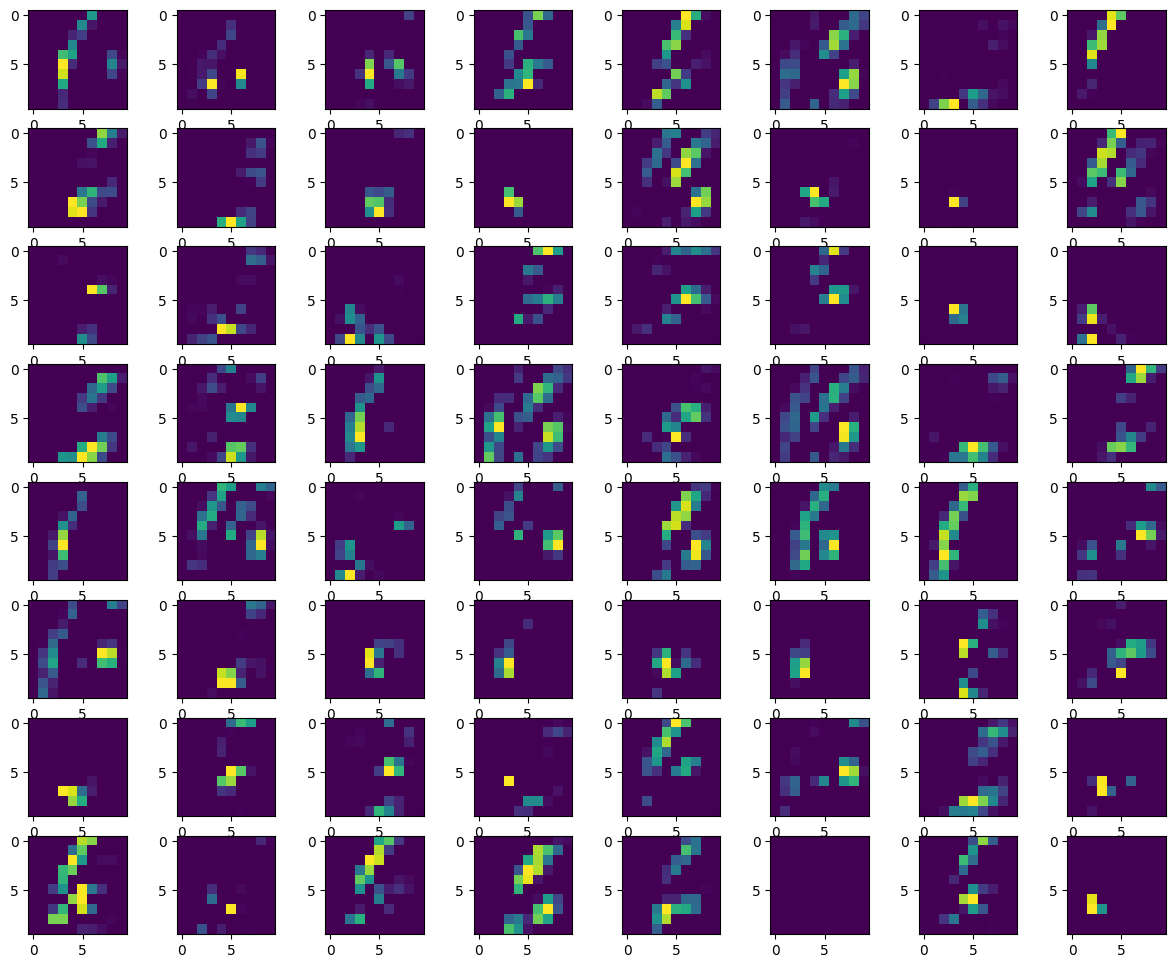

In [53]:
from tensorflow.keras import backend as K

inds = correct_indices

num = inds[np.random.randint(0, len(inds))]

img = X_test[num]
img = np.expand_dims(img, axis=0)   # Keras requires the image to be in 4D, so we add an extra dimension to it.

plt.figure()
plt.imshow(img.reshape(28,28), interpolation='none')
plt.title("Predicted {}, Labeled {}".format(y_predicted[num], y_test[num]))
plt.show()

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function([model.inputs], [layer.output])

    convolutions = _convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i])

for i in range(5):
    print('layer: ', i+1 , model.layers[i])
    visualize(model.layers[i]) # visualize layers outputs
    plt.show()